In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
import json 
import os 
from collections import defaultdict


#Plotting maps
import folium #  conda install -c conda-forge folium
from folium import plugins
import earthpy as et # 

# Our helpers
#from neural import predict_future # Wrapper to use RNNs

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot
#Geographic coordinates for visualizing 
county_path = os.path.join(os.getcwd(),'data/', 'geoworld-countries.json') 
county_geojson = json.load(open(county_path))

## 1) How much human food resources are available in African countries?

### 1.1) Preprocessing

To answer this important question, we will need to import data from the **FAO Dataset**. More specifically, we will focus on the section **Food Balance Sheet** with respect to African countries only. 

In [3]:
FAO_food_balance = pd.read_csv("Data/FoodBalanceSheets_E_Africa_1.csv",encoding='latin-1');

Firstly, we will **remove** all the columns with title **"Y----F"** as they contain information about how the data was obtained (Calculated, Regression, Aggregate, FAO Estimation). In this context we will consider that FAO is a *highly renowned Agency* and hence we can assume these values are truthful without loss of generality. Furthermore we thought that it would be very handy to have numbers as columns representing years instead of **"Y----"**. We proceed on removing the letter **Y**.

In [4]:
col_to_drop = FAO_food_balance.columns[FAO_food_balance.columns.str.endswith("F")]; #creating a list of columns to be removed
FAO_food_balance = FAO_food_balance.drop(columns=col_to_drop);
FAO_food_balance.columns=FAO_food_balance.columns.str.replace("Y","") #rename the columns by deleting "Y" at the beginning

Secondly, we replace all the **NAN** values with **0** as Item was not available.

In [5]:
FAO_food_balance = FAO_food_balance.fillna(0);

The third step to complete **the cleaning** of FAO_food_balance consists of adapting names of countries in order to have consistency along our different dataframes. Since some countries changed their name over the years we will rename them. In particular, **Swaziland** to **Eswatini** and **South Africa** to **Southern Africa**.

In [6]:
FAO_food_balance['Area'] = FAO_food_balance['Area'].replace("Swaziland", "Eswatini");
FAO_food_balance['Area'] = FAO_food_balance['Area'].replace("South Africa", "Southern Africa");

Our Dataframe looks like this:

In [7]:
FAO_food_balance.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,1961,1962,1963,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,4,Algeria,2501,Population,511,Total Population - Both sexes,1000 persons,11561.0,11845.0,12136.0,...,33461.0,33961.0,34507.0,35097.0,35725.0,36383.0,37063.0,37763.0,38482.0,39208.0
1,4,Algeria,2511,Wheat and products,5511,Production,1000 tonnes,686.0,1507.0,1590.0,...,2731.0,2415.0,2688.0,2319.0,1111.0,2953.0,2605.0,2555.0,3432.0,3299.0
2,4,Algeria,2511,Wheat and products,5611,Import Quantity,1000 tonnes,469.0,501.0,374.0,...,5123.0,5697.0,4987.0,4885.0,6508.0,5757.0,5109.0,7487.0,6385.0,6343.0
3,4,Algeria,2511,Wheat and products,5072,Stock Variation,1000 tonnes,353.0,-409.0,-408.0,...,-456.0,-606.0,-459.0,-1.0,156.0,-484.0,515.0,-1050.0,-350.0,-180.0
4,4,Algeria,2511,Wheat and products,5911,Export Quantity,1000 tonnes,46.0,12.0,33.0,...,7.0,13.0,7.0,14.0,24.0,37.0,39.0,5.0,5.0,2.0


Analysing our DataFrame *FAO_food_balance* we can see that it's already well structured since it contains many key - value couples such as **Item Code - Item** and **Element Code - Element** . More specifically, we will take advantage of this structure to filter out only rows characterized by **Grand total** as an **Item** and **Food supply (kcal/capita/day)** as an **Element**. The corresponding key-values are **(Item Code, 2901) and (Element Code, 664)**.
A reference to the documentation in the [FAO Website](http://www.fao.org/faostat/en/#data/FBS) explains the legend for Element Code and Element Item extensively. 

In order to keep our original Dataframe *FAO_food_balance* as a reference we create a new Dataframe *FAO_food_supply* in which we just keep **countries** and **food supplies** for every **year**.

In [8]:
FAO_food_supply = FAO_food_balance[(FAO_food_balance["Item Code"] == 2901) & (FAO_food_balance["Element Code"] == 664)];
FAO_food_supply = FAO_food_supply.drop(columns=["Area Code","Item Code","Item","Element Code","Element", "Unit"])

We can now group group by **Area** and see the supplies derived from each item available in countries for that particular year.

In [9]:
FAO_food_supply = FAO_food_supply.set_index("Area")
FAO_food_supply.head()

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,
Algeria,1619.0,1569.0,1528.0,1540.0,1591.0,1571.0,1647.0,1706.0,1705.0,1675.0,...,2987.0,2958.0,3047.0,3041.0,3048.0,3110.0,3142.0,3217.0,3272.0,3296.0
Angola,1798.0,1819.0,1853.0,1862.0,1877.0,1890.0,1921.0,1856.0,1946.0,1965.0,...,2030.0,2077.0,2119.0,2173.0,2245.0,2303.0,2345.0,2407.0,2384.0,2473.0
Benin,1736.0,1758.0,1703.0,1669.0,1812.0,1804.0,1833.0,1935.0,1871.0,1812.0,...,2461.0,2435.0,2450.0,2564.0,2521.0,2565.0,2555.0,2598.0,2610.0,2619.0
Botswana,1976.0,1909.0,1972.0,2001.0,2005.0,1947.0,2010.0,2052.0,2013.0,2035.0,...,2191.0,2198.0,2150.0,2166.0,2184.0,2199.0,2234.0,2273.0,2342.0,2326.0
Burkina Faso,1326.0,1308.0,1452.0,1555.0,1571.0,1560.0,1587.0,1602.0,1604.0,1546.0,...,2505.0,2463.0,2559.0,2546.0,2588.0,2639.0,2681.0,2664.0,2707.0,2720.0


In order to check for anomalies in our data, we would like to analyze the **timeline**. We therefore transpose the dataframe and plot the timeline of how food supply in different countries evolved. Legend was suppressed as it is too large.

In [10]:
FAO_food_supply = FAO_food_supply.transpose();

In [11]:
#converting the year from string to int
FAO_food_supply.index = FAO_food_supply.index.astype(int)

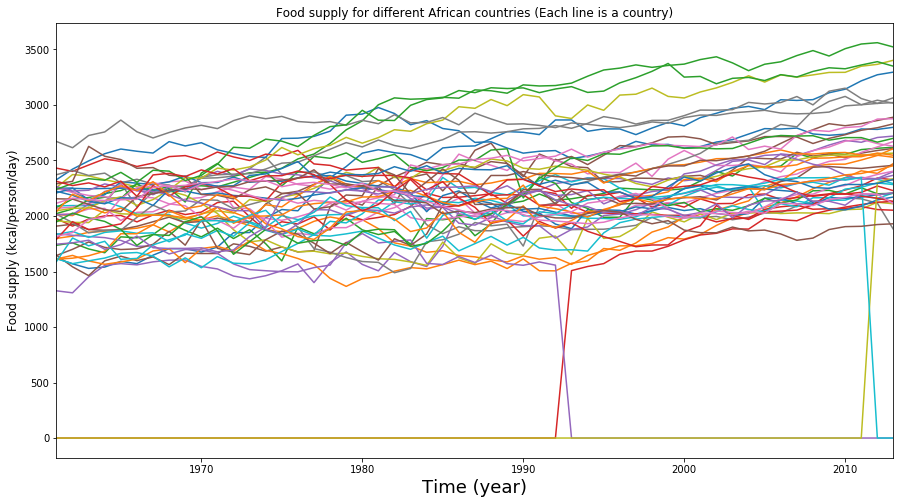

In [12]:
FAO_food_supply.plot.line(legend = False)
plt.xlabel("Time (year)", fontsize=18)
plt.ylabel("Food supply (kcal/person/day)", fontsize=12)
plt.title("Food supply for different African countries (Each line is a country)");

This analysis shows that there are two inconsistencies. We therefore check for countries containing values equal to zero.

In [13]:
FAO_food_supply.columns.values[(FAO_food_supply == 0).any()]

array(['Ethiopia', 'Ethiopia PDR', 'Sudan', 'Sudan (former)'],
      dtype=object)

We notice that **Sudan** and **Ethiopia** appear twice as "Sudan" and "Sudan (former)" and "Ethiopia" and "Ethiopia PDR" respectively. This is due to the fact that South Sudan gained independence in 2011 (reference to https://en.wikipedia.org/wiki/South_Sudan), and the foundation of the Federal Democratic Republic of Ethiopia (reference to https://en.wikipedia.org/wiki/Ethiopia) in 1991. From then on, Ethiopia PDR was listed as Ethiopia. With food supply being consistently constant even after division, the newly introduced country "Sudan" is assumed to further on have accounted for both countries. For this reason, we will consider them to be one single country. 
Consequently, the two countries' data is merged into one continuous set each.

In [14]:
FAO_food_supply_cleared = FAO_food_supply.copy()
FAO_food_supply_cleared['Sudan'] += FAO_food_supply_cleared['Sudan (former)']
FAO_food_supply_cleared = FAO_food_supply_cleared.drop('Sudan (former)', 1)
FAO_food_supply_cleared['Ethiopia'] += FAO_food_supply_cleared['Ethiopia PDR']
FAO_food_supply_cleared = FAO_food_supply_cleared.drop('Ethiopia PDR', 1)

Let's plot the newly generated data:

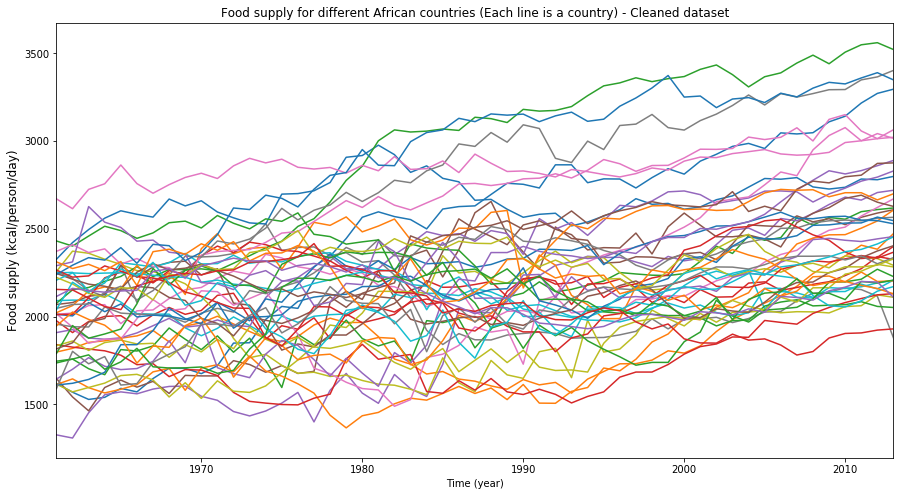

In [15]:
FAO_food_supply_cleared.plot.line(legend = False)
plt.xlabel("Time (year)")
plt.ylabel("Food supply (kcal/person/day)", fontsize=12)
plt.title("Food supply for different African countries (Each line is a country) - Cleaned dataset");

Next, we want to add more columns representing future years until 2020 to prepare cells for extrapolation to make predictions about possible scenarios.

In [16]:
# Adding columns for the new years
from helpfunc import prepare_future
FAO_food_supply_cleared = prepare_future(FAO_food_supply_cleared, 2014, 2020)

### 1.2) Extrapolation
First of all, we want to simulate data until 2020 to match the population data. Furthermore, we also want to be able to make predicitions for individual countries to assess if they might run into food shortages in the near future.  
The prediction mae years are done by using a "*Recurrent Neural Network (RNN)*" and a window of size 10. Basically what we will do here is using all the past history of each country (windowed in block of 10 years each) to run a neural network and try to predict the future behaviour (up to 2020). The prediction won't be of high accuracy, as we don't have many future or many data to use. However, during our test using the data we already known we find that the neural networks are able to predict good estimations.  
As we don't want precise data, the **_estimations_** achieved by using ML are here more than acceptable for our purpose.  
*Credits*: We don't know much on RNN, so the network using here is adapted from the *Time series forecasting tutorial* on **Tensorflow**, available [here](https://www.tensorflow.org/tutorials/structured_data/time_series)  
*Note*: we already run the networks and saved the results on Colab, running them each time requires more than an hour on Colab. For this reason, we just use the pickle here instead of running the network.

In [17]:
#FAO_food_supply_cleared = predict_future(FAO_food_supply_cleared, "africa.pkl")
FAO_food_supply_cleared = pd.read_pickle("africa.pkl")

Plotting the results:

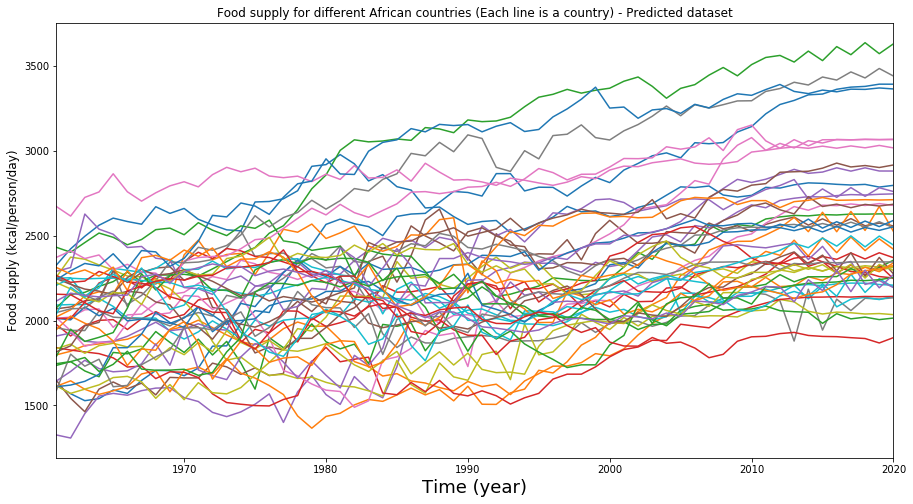

In [18]:
FAO_food_supply_cleared.plot.line(legend = False)
plt.xlabel("Time (year)", fontsize=18)
plt.ylabel("Food supply (kcal/person/day)", fontsize=12)
plt.title("Food supply for different African countries (Each line is a country) - Predicted dataset");

### 1.3) Visualazing the data interactively

In [ ]:
#Don't run
import geopandas as gpd
from shapely.geometry import shape


data = county_geojson.json()
for d in data:
    d['the_geom'] = shape(d['the_geom'])

gdf = gpd.GeoDataFrame(data).set_geometry('the_geom')
gdf.head()

As we can see the in the plot above, most of the countries show a positive trend of growth in terms of food supply since 1961 to 2020. More specifically, the functions presents many drops that can be addressed to civil wars, economical crysis as well as political instability. **FOR EXAMPLE**

In [25]:
def african_map(map_instance,value_list,colorbrew,legend_name):
    #Defining a code list of countries for which we have geographical coordinates
    african_country_codes = ["DZA","AGO","BEN","BWA","BFA","MISSING","CMR","CAF","TCD","COD","CIV",
                         "DJI","EGY","SWZ","ETH","GAB","GMB","GHA","GNQ","GNB","KEN","LSO","LBR",
                         "MDG","MWI","MLI","MRT","MISSING","MAR","MOZ","NAM","NER","NGA","RWA","MISSING"
                         ,"SEN","SLE","ZAF","SDN","TGO","TUN","UGA","TZA","ZMB","ZWE"]
    #Creating a dataframe 
    countries_africa = pd.DataFrame()
    countries_africa["country_name"]=value_list.index
    countries_africa["country_code"]=african_country_codes
    
    #Creating plotdata that will be the input of Choropleth map
    plotdata= countries_africa.copy()
    plotdata["val"]=value_list.values
    plotdata= plotdata[plotdata.country_code!="MISSING"] #Dropping Cabo Verde, Mauritius and Sao Tome and Principe as we don't have geocoordinates
    plotdata= plotdata.drop(columns="country_name")
    
    
    #choropleth maps bind Pandas Data Frames and json geometries. This allows us to quickly visualize data combinations
    folium.Choropleth(
        geo_data=county_geojson,
        name='choropleth',
        data=plotdata,
        columns= ["country_code","val"],
        key_on='feature.id',
        fill_color=colorbrew,
        legend_name=legend_name,
        smooth_factor=0,
        #fill_opacity=1,
        line_opacity=1
    ).add_to(map_instance)
    style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
    #highlight_function = lambda x: {'fillColor': '#000000', 
                               # 'color':'#000000', 
                                #'fillOpacity': 0.1, 
                                #'weight': 0.1}
    trying = folium.features.GeoJson(
        data = county_geojson,
        style_function=style_function, 
        control=False,
       #highlight_function=highlight_function, 
        tooltip=folium.features.GeoJsonTooltip(
        fields=['name'],
        aliases=['Country: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
        )
    )
    map_instance.add_child(trying)
    map_instance.keep_in_front(trying)
    folium.LayerControl().add_to(trying)
    return map_instance

Let's move to a more effective visualization of *Food supply for different African countries* in 2020:

In [26]:
#Initialize map
m = folium.Map(location=[8, 15], zoom_start=3, tiles=None,min_zoom=3,max_zoom=3)
colorberew = 'Blues'
legend_name = "Food supply (kcal/person/day)"
values = FAO_food_supply_cleared.T[2020]
#Apply function
african_map(m,values,colorberew,legend_name)

## 2) What is the ideal amount of kcal each African country need?
In this first part, we compute **kcal demand** for males and females for every age group. Secondly, we will assert an extensive analysis on **African demographics**. Finally, we will be able to combine kcal demand with African population data into a unique dataframe that will be the answer of our inital question: **What is the kcal demand of a regular person in order to be healthy?**

First off, we load the calories demand datasets scraped from the webpage [Calories](https://health.gov/dietaryguidelines/2015/guidelines/appendix-2/). This information will be matched with the population datsets to receive total calories demand in each country, each year.

In [27]:
male_calory_demand = pd.read_excel("data/calories_demand.xlsx",header =None, sheet_name=0, names=['age', 'sedentary', 'moderate', 'active'])

In [28]:
females_calory_demand =  pd.read_excel("data/calories_demand.xlsx",header =None, sheet_name=1, names=['age', 'sedentary', 'moderate', 'active'])

In order to better work with the information we have collected, we will make some simplifications on the data. Mainly, we will:
- take the **active lifestyle** column in the calories demands database. According to the [World Health Organization](https://www.afro.who.int/health-topics/physical-activity), regular physical activity helps to maintain a healthy body and reduces the risk of disease.
- group the ages into ranges that match the ranges provided in the World Population Database

In [29]:
male_calories_act = male_calory_demand.drop(columns=['sedentary', 'moderate'])
females_calories_act = females_calory_demand.drop(columns=['sedentary', 'moderate'])
male_calories_act.rename(columns={'active':'input kcal'}, inplace=True)
females_calories_act.rename(columns={'active':'input kcal'}, inplace=True)

We have now obtained a caloric demand for simpler calculations in the future and stored in the two precedent datasets.  
Now, we need a  way to match the age groups in this dataframe to the ones in the population database we obtained. As such, let's analyse how ages are represented in our calory demand dataframes.

In [30]:
male_calories_act['age'].unique()

array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       '19-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50',
       '51-55', '56-60', '61-65', '66-70', '71-75', '76 and up', nan],
      dtype=object)

We can see that there are ranges of ages with different sizes (which makes sense, because different age groups have different caloric needs). We'll present a function that creates one row per individual age.

In [31]:
def single_age(age_range):
    if type(age_range) ==  float: # nans are the only floats in the age column
        return -1
    elif type(age_range) == int:
        return age_range
    elif re.search('\d-\d', age_range):
        group = age_range.split('-')
        return list(range(int(group[0]), int(group[1])+1))
    elif age_range == "76 and up":
        return list(range(76, 101+1))

In [32]:
def explode_age(data_frame):
    accum = []
    for i in data_frame.index:
        row = data_frame.loc[i]
        single = single_age(row['age'])
        if single == -1: # we ignore the nan values, as their rows are empty
            continue
        if type(single) == int:
            accum.append((single, row['input kcal']))
        elif type(single) == list:
            accum.extend([(x, row['input kcal']) for x in single]) 
    return pd.DataFrame(accum, columns=data_frame.columns)

We apply the function to our two dataframe:

In [33]:
male_explode = explode_age(male_calories_act)
female_explode = explode_age(females_calories_act)

In [34]:
male_explode['age'].unique()

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101])

Ages are now unique in each dataframe ( `male_explode` and `female_explode` ) and there's a caloric input value for each of them.

The last step to allow the match with the population database is to build the **same age groups** we have in that set.  
We do this in the next two functions:

In [35]:
def group(age):
    i = int(5*(age//5))
    return "{}-{}".format(i, i+4)

In [36]:
def compress_ages(data_frame):
    accum = defaultdict(list)
    for i in data_frame.index:
        row = data_frame.loc[i]
        g_id = group(row['age'])
        if g_id == "100-104":
            g_id = "100+"
        accum[g_id].append(row['input kcal'])
    for i in accum:
        accum[i] = sum(accum[i]) / len(accum[i])
    return pd.DataFrame.from_dict(accum, orient='index')

We can lastly apply the functions to the dataframes:

In [37]:
new_male_need = compress_ages(male_explode)
new_female_need = compress_ages(female_explode)

We also use the age group as new index and rename the columns:

In [38]:
new_male_need.index.name = 'age_group'
new_male_need = new_male_need.rename(columns={0: 'input kcal'})
new_female_need.index.name = 'age_group'
new_female_need = new_female_need.rename(columns={0: 'input kcal'})

Let's have a look at the result we have achieved and collected in our matchable dataframe `new_male_need` and `new_female_need`. The unit here is **kcal/person/day**.

In [39]:
new_male_need.head()

,input kcal
age_group,
0-4,1333.333333
5-9,1840.000000
10-14,2440.000000
15-19,3120.000000
20-24,3000.000000


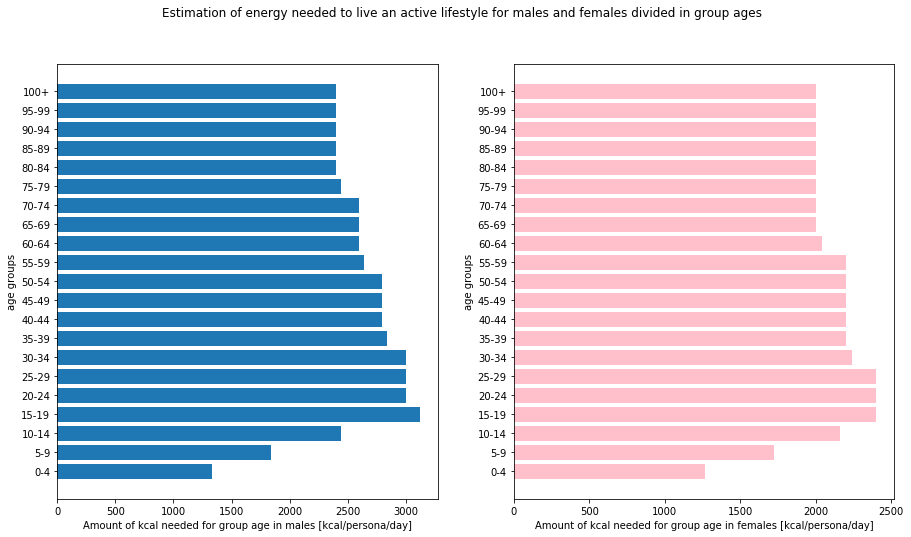

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].barh(new_male_need.index, new_male_need["input kcal"])
axes[1].barh(new_female_need.index, new_female_need["input kcal"],color="#ffc0cb")
axes[0].set_xlabel("Amount of kcal needed for group age in males [kcal/persona/day]")
fig.suptitle("Estimation of energy needed to live an active lifestyle for males and females divided in group ages")
axes[1].set_xlabel("Amount of kcal needed for group age in females [kcal/persona/day]")
axes[0].set_ylabel("age groups")
axes[1].set_ylabel("age groups");

### 2- How many people live in Africa?

In this second part of our analysis, we load the list of **African countries**. Secondly, we load the **World Population Database** (United Nation) and therefore we obtain two dataframes: one for males and the other one for females.

In [46]:
with open ("data/african_countries.txt",'r') as af_c:
    af_countries = [line.rstrip() for line in af_c] #loading list

We need to check if the FAO Database contains data regarding **every country** in Africa. We will check the intersection with the list **af_countries**.

In [47]:
af_to_remove = list(set(af_countries)- set(FAO_food_supply_cleared.columns.values))
print("List of countries for which no data is available: "+ str(af_to_remove))

List of countries for which no data is available: ['Somalia', 'Democratic Republic of the Congo', 'Burundi', 'Mayotte', 'Equatorial Guinea', 'Eritrea', 'South Sudan', 'Seychelles', 'Comoros', 'Réunion', 'Western Sahara', 'Libya']


As expected, many countries were not present in the FAO Database. The countries to remove are the following: **Eritrea, Burundi, Comoros, Democratic Republic of the Congo, Equatorial Guinea, Libya ,Seychelles, Western Sahara, South Sudan, and Somalia**. Furthermore, **Mayotte** and **Réunion** are French territory islands so they will be removed as well.

In [48]:
af_countries = [i for i in af_countries if not i in af_to_remove]
af_to_remove = list(set(af_countries)- set(FAO_food_supply_cleared.columns.values))
print("List of countries for which no data is available: "+ str(af_to_remove))

List of countries for which no data is available: []


**World Population Database** (United Nation) is now loaded and cleaned. This preprocessing is necessary in order to sort things out for next more complex steps.  
**A note**: Since the population data is per 1000 people, all entries are multiplied by the same factor (1000) to return to the real value.

In [45]:
#loading datasets
pop_male = pd.read_excel("data/POPULATION_BY_AGE_MALE.xlsx", sheet_name="ESTIMATES")
pop_female = pd.read_excel("data/POPULATION_BY_AGE_FEMALE.xlsx", sheet_name="ESTIMATES")

In [49]:
#cleaning male population dataset
pop_male.drop(columns=["Index", "Variant", "Notes", "Country code", "Type", "Parent code"], inplace=True)
pop_male.rename(columns={"Reference date (as of 1 July)": "year", "Region, subregion, country or area *": "country"}, inplace=True)
#taking only african countries
pop_male = pop_male[pop_male['country'].isin(af_countries)]

#cleaning female dataset
pop_female.drop(columns=["Index", "Variant", "Notes", "Country code", "Type", "Parent code"], inplace=True)
pop_female.rename(columns={"Reference date (as of 1 July)": "year", "Region, subregion, country or area *": "country"}, inplace=True)
#only african
pop_female = pop_female[pop_female['country'].isin(af_countries)]

In [50]:
#take into consideration the 1000 of population from the beginning now
pop_male.iloc[:, 2:] = pop_male.iloc[:, 2:]*1000
pop_female.iloc[:, 2:] = pop_female.iloc[:, 2:]*1000

Let's have a look at the final version of male population data grouped by age:

In [51]:
pop_male.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
420,Djibouti,1950,6128,4593,3828,3247,2727,2266,1873,1538,...,589,422,277,160,74,24,7,0,0,0
421,Djibouti,1955,5556,5527,4487,3773,3168,2639,2186,1800,...,696,506,337,198,94,33,7,0,0,0
422,Djibouti,1960,7201,5360,5668,4640,3867,3218,2672,2203,...,868,631,428,256,126,46,11,0,0,0
423,Djibouti,1965,10888,7814,6324,6545,5316,4389,3642,3006,...,1191,872,591,358,179,71,16,2,0,0
424,Djibouti,1970,15553,11828,9094,7514,7519,6072,4994,4120,...,1646,1208,826,503,259,102,24,3,0,0


In this context, the population dataframe for males **pop_male** and for females **pop_female** contains measurements of population censi, for years from 1950 to 2020 with a frequency of **5 years**. Next, data is interpolated in order to obtain values for intermediate years. 

First of all, we want to look at the data in order to understand what the population growth's **trend** over the years will be.  
For this purpose, only some of the columns from the two datasets are considered representing the trends. Specifically, we are focusing on the range **10-39 years**, that contains the majority of the population.

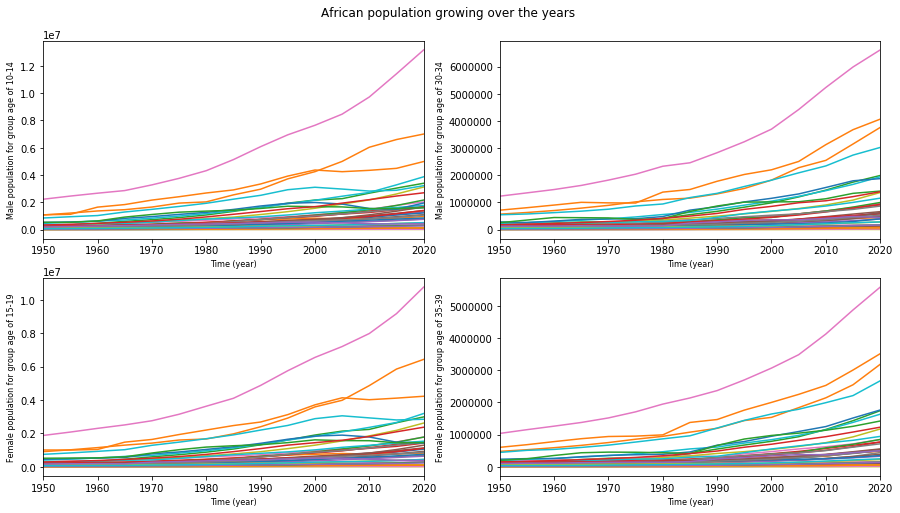

In [65]:
fig, axs = plt.subplots(2, 2)
x = pop_male.year.drop_duplicates()
for country in pop_male.country.drop_duplicates():
    y = pop_male[(pop_male.country==country)]["10-14"]    
    axs[0, 0].plot(x,y)
axs[0, 0].set_xlabel("Time (year)",fontsize=8)
axs[0, 0].set_ylabel("Male population for group age of 10-14", fontsize=8);
axs[0, 0].set_xlim(1950,2020)


for country in pop_male.country.drop_duplicates():
    y = pop_male[(pop_male.country==country)]["30-34"]
    axs[0, 1].plot(x,y)
axs[0, 1].set_xlabel("Time (year)",fontsize=8)
axs[0, 1].set_ylabel("Male population for group age of 30-34", fontsize=8);
axs[0, 1].set_xlim(1950,2020)


x = pop_female.year.drop_duplicates()
for country in pop_female.country.drop_duplicates():
    y = pop_female[(pop_female.country==country)]["15-19"]
    axs[1, 0].plot(x,y)
axs[1, 0].set_xlabel("Time (year)",fontsize=8)
axs[1, 0].set_ylabel("Female population for group age of 15-19", fontsize=8);
axs[1, 0].set_xlim(1950,2020)


for country in pop_female.country.drop_duplicates():
    y = pop_female[(pop_female.country==country)]["35-39"]
    axs[1, 1].plot(x,y)
axs[1, 1].set_xlabel("Time (year)",fontsize=8)
axs[1, 1].set_ylabel("Female population for group age of 35-39", fontsize=8);
axs[1, 1].set_xlim(1950,2020)


fig.suptitle("African population growing over the years", y=0.94);

We can now assume that the population grows linearly over time, a plausible result is accomplished by interpolating with a linear method. The dataframe obtained will keep the same characteristics of the previous one with the difference of frequency which now is **1 year**.

## This code needs to be commented

In [66]:
coll = ['country', 'year'] 

pop_temp_m= pd.DataFrame(columns = coll )
pop_male_yearly= pd.DataFrame(columns = coll )
for country in pop_male.country.drop_duplicates():
    for ages in pop_male.columns[2:]:
        x = pop_male.year.drop_duplicates()
        y = pop_male[(pop_male.country==country)][ages].astype(float)
        xnew = np.arange(1950,2021)
        ynew = np.interp(xnew, x, y, left=None, right=None, period=None)
        pop_temp_m[ages] = ynew
        pop_temp_m["country"]=country
        pop_temp_m["year"]=xnew  
    pop_male_yearly = pop_male_yearly.append(pop_temp_m, sort=False)
pop_male_yearly = pop_male_yearly.reset_index().drop(columns="index")

    
pop_temp_f= pd.DataFrame(columns = coll )
pop_female_yearly= pd.DataFrame(columns = coll )
for country in pop_female.country.drop_duplicates():
    for ages in pop_female.columns[2:]:
        x = pop_female.year.drop_duplicates()
        y = pop_female[(pop_female.country==country)][ages].astype(float)
        xnew = np.arange(1950,2021)
        ynew = np.interp(xnew, x, y, left=None, right=None, period=None)
        pop_temp_f[ages] = ynew
        pop_temp_f["country"]=country
        pop_temp_f["year"]=xnew  
    pop_female_yearly = pop_female_yearly.append(pop_temp_f, sort=False)
pop_female_yearly = pop_female_yearly.reset_index().drop(columns="index")

Let's see how the new dataframes for males and females population look like:

In [67]:
pop_male_yearly.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Djibouti,1950,6128.0,4593.0,3828.0,3247.0,2727.0,2266.0,1873.0,1538.0,...,589.0,422.0,277.0,160.0,74.0,24.0,7.0,0.0,0.0,0.0
1,Djibouti,1951,6013.6,4779.8,3959.8,3352.2,2815.2,2340.6,1935.6,1590.4,...,610.4,438.8,289.0,167.6,78.0,25.8,7.0,0.0,0.0,0.0
2,Djibouti,1952,5899.2,4966.6,4091.6,3457.4,2903.4,2415.2,1998.2,1642.8,...,631.8,455.6,301.0,175.2,82.0,27.6,7.0,0.0,0.0,0.0
3,Djibouti,1953,5784.8,5153.4,4223.4,3562.6,2991.6,2489.8,2060.8,1695.2,...,653.2,472.4,313.0,182.8,86.0,29.4,7.0,0.0,0.0,0.0
4,Djibouti,1954,5670.4,5340.2,4355.2,3667.8,3079.8,2564.4,2123.4,1747.6,...,674.6,489.2,325.0,190.4,90.0,31.2,7.0,0.0,0.0,0.0


In [68]:
pop_female_yearly.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Djibouti,1950,6065.0,4583.0,3819.0,3238.0,2736.0,2295.0,1911.0,1574.0,...,655.0,487.0,334.0,202.0,100.0,34.0,11.0,2.0,0.0,0.0
1,Djibouti,1951,5948.6,4764.2,3949.6,3342.8,2824.4,2369.8,1973.8,1627.2,...,679.0,505.8,347.6,211.2,105.4,37.0,11.0,2.0,0.0,0.0
2,Djibouti,1952,5832.2,4945.4,4080.2,3447.6,2912.8,2444.6,2036.6,1680.4,...,703.0,524.6,361.2,220.4,110.8,40.0,11.0,2.0,0.0,0.0
3,Djibouti,1953,5715.8,5126.6,4210.8,3552.4,3001.2,2519.4,2099.4,1733.6,...,727.0,543.4,374.8,229.6,116.2,43.0,11.0,2.0,0.0,0.0
4,Djibouti,1954,5599.4,5307.8,4341.4,3657.2,3089.6,2594.2,2162.2,1786.8,...,751.0,562.2,388.4,238.8,121.6,46.0,11.0,2.0,0.0,0.0


Lastly, we will compute the total population per year. This new dataframe **pop_tot** will be useful for the next section of our analysis.

In [69]:
pop_tot = pop_male_yearly.copy()
pop_tot.iloc[:, 2:] = pop_male_yearly.iloc[:, 2:] + pop_female_yearly.iloc[:, 2:]
sum_ind = pop_tot.columns[2:]
pop_tot['Population'] = pop_tot[sum_ind].sum(axis=1)
pop_tot.drop(columns=sum_ind, inplace=True)

For the next analysis we will need to match this data with the `FAO_food_Balance`. We proceed to give to our population data the same shape as the other datasets.

In [70]:
# We sort values by year, we group them by country and we tranpose the values in columns Population.
# In the function lambda we reset the index. The unstack() allows to return a new dataframe with 
# a new level of columns.

years = list(pop_tot.year.drop_duplicates().sort_values())
pop_tot = pop_tot.sort_values('year').groupby("country")['Population'].apply(lambda df: df.reset_index(drop=True)).unstack()
pop_tot.columns = years
pop_tot.index.name = 'Country'

In [71]:
pop_tot.head()

,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country,,,,,,,,,,,,,,,,,,,,,
Algeria,8872250.0,9052656.0,9233062.0,9413468.0,9593874.0,9774280.0,10030996.8,10287713.6,10544430.4,10801147.2,...,36727564.8,37477678.6,38227792.4,38977906.2,39728020.0,40552624.6,41377229.2,42201833.8,43026438.4,43851043.0
Angola,4548021.0,4647067.0,4746113.0,4845159.0,4944205.0,5043251.0,5125588.4,5207925.8,5290263.2,5372600.6,...,24261873.6,25167500.2,26073126.8,26978753.4,27884380.0,28880757.6,29877135.2,30873512.8,31869890.4,32866268.0
Benin,2255222.0,2264896.0,2274570.0,2284244.0,2293918.0,2303592.0,2329197.0,2354802.0,2380407.0,2406012.0,...,9474595.6,9749937.2,10025278.8,10300620.4,10575962.0,10885409.2,11194856.4,11504303.6,11813750.8,12123198.0
Botswana,412541.0,422703.4,432865.8,443028.2,453190.6,463353.0,471229.0,479105.0,486981.0,494857.0,...,2013828.0,2040550.0,2067272.0,2093994.0,2120716.0,2166897.8,2213079.6,2259261.4,2305443.2,2351625.0
Burkina Faso,4284455.0,4330995.0,4377535.0,4424075.0,4470615.0,4517155.0,4579581.8,4642008.6,4704435.4,4766862.2,...,16106292.0,16607373.0,17108454.0,17609535.0,18110616.0,18669148.4,19227680.8,19786213.2,20344745.6,20903278.0


### 3- Estimantion of ideal human food demand in Africa 

Now we multiply each column of the population data for each matching `age_group` in the calories table (which is squeezed to enable multiplication, similar to transposing rows/columns of the dataset).  
We obtain two datasets: `total_cal_male` and `total_cal_female` reporting total calories needed for **each country in each year per age group per gender**. 
The unit here is **kcal/day**.

In [72]:
#total calories male
pop_mal_mult = pop_male_yearly.drop(columns=["country", "year"])
total_cal_male = pop_mal_mult.multiply(new_male_need.squeeze()) # squeeze adapts the dimension of the dataframe
total_cal_male.insert(0,"country",pop_male_yearly.country)
total_cal_male.insert(1,"year",pop_male_yearly.year)
total_cal_male.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Djibouti,1950,8.170667e+06,8451120.0,9340320.0,10130640.0,8181000.0,6798000.0,5619000.0,4367920.0,...,1554960.0,1097200.0,720200.0,416000.0,180560.0,57600.0,16800.0,0.0,0.0,0.0
1,Djibouti,1951,8.018133e+06,8794832.0,9661912.0,10458864.0,8445600.0,7021800.0,5806800.0,4516736.0,...,1611456.0,1140880.0,751400.0,435760.0,190320.0,61920.0,16800.0,0.0,0.0,0.0
2,Djibouti,1952,7.865600e+06,9138544.0,9983504.0,10787088.0,8710200.0,7245600.0,5994600.0,4665552.0,...,1667952.0,1184560.0,782600.0,455520.0,200080.0,66240.0,16800.0,0.0,0.0,0.0
3,Djibouti,1953,7.713067e+06,9482256.0,10305096.0,11115312.0,8974800.0,7469400.0,6182400.0,4814368.0,...,1724448.0,1228240.0,813800.0,475280.0,209840.0,70560.0,16800.0,0.0,0.0,0.0
4,Djibouti,1954,7.560533e+06,9825968.0,10626688.0,11443536.0,9239400.0,7693200.0,6370200.0,4963184.0,...,1780944.0,1271920.0,845000.0,495040.0,219600.0,74880.0,16800.0,0.0,0.0,0.0


In [73]:
#total calories female
pop_fem_mult = pop_female_yearly.drop(columns=["country", "year"])
total_cal_female = pop_fem_mult.multiply(new_female_need.squeeze()) 
total_cal_female.insert(0,"country",pop_male_yearly.country)
total_cal_female.insert(1,"year",pop_male_yearly.year)
total_cal_female.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Djibouti,1950,7.682333e+06,7882760.0,8249040.0,7771200.0,6566400.0,5508000.0,4280640.0,3462800.0,...,1441000.0,993480.0,668000.0,404000.0,200000.0,68000.0,22000.0,4000.0,0.0,0.0
1,Djibouti,1951,7.534893e+06,8194424.0,8531136.0,8022720.0,6778560.0,5687520.0,4421312.0,3579840.0,...,1493800.0,1031832.0,695200.0,422400.0,210800.0,74000.0,22000.0,4000.0,0.0,0.0
2,Djibouti,1952,7.387453e+06,8506088.0,8813232.0,8274240.0,6990720.0,5867040.0,4561984.0,3696880.0,...,1546600.0,1070184.0,722400.0,440800.0,221600.0,80000.0,22000.0,4000.0,0.0,0.0
3,Djibouti,1953,7.240013e+06,8817752.0,9095328.0,8525760.0,7202880.0,6046560.0,4702656.0,3813920.0,...,1599400.0,1108536.0,749600.0,459200.0,232400.0,86000.0,22000.0,4000.0,0.0,0.0
4,Djibouti,1954,7.092573e+06,9129416.0,9377424.0,8777280.0,7415040.0,6226080.0,4843328.0,3930960.0,...,1652200.0,1146888.0,776800.0,477600.0,243200.0,92000.0,22000.0,4000.0,0.0,0.0


Once we have the calories needed for both gender, we can add them together easily to achieve total calories needed for **each country in each year per age group**, and we collect them in the dataframe `total_cal_ages`. The unit is still **kcal/day**.

In [74]:
#copy the male inside the total (to mantain country and year columns) and sum with female
total_cal_ages = total_cal_male.copy()
sum_ind = total_cal_ages.columns[2:]
total_cal_ages[sum_ind] = total_cal_ages[sum_ind] + total_cal_female[sum_ind]
total_cal_ages.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Djibouti,1950,1.585300e+07,16333880.0,17589360.0,17901840.0,14747400.0,12306000.0,9899640.0,7830720.0,...,2995960.0,2090680.0,1388200.0,820000.0,380560.0,125600.0,38800.0,4000.0,0.0,0.0
1,Djibouti,1951,1.555303e+07,16989256.0,18193048.0,18481584.0,15224160.0,12709320.0,10228112.0,8096576.0,...,3105256.0,2172712.0,1446600.0,858160.0,401120.0,135920.0,38800.0,4000.0,0.0,0.0
2,Djibouti,1952,1.525305e+07,17644632.0,18796736.0,19061328.0,15700920.0,13112640.0,10556584.0,8362432.0,...,3214552.0,2254744.0,1505000.0,896320.0,421680.0,146240.0,38800.0,4000.0,0.0,0.0
3,Djibouti,1953,1.495308e+07,18300008.0,19400424.0,19641072.0,16177680.0,13515960.0,10885056.0,8628288.0,...,3323848.0,2336776.0,1563400.0,934480.0,442240.0,156560.0,38800.0,4000.0,0.0,0.0
4,Djibouti,1954,1.465311e+07,18955384.0,20004112.0,20220816.0,16654440.0,13919280.0,11213528.0,8894144.0,...,3433144.0,2418808.0,1621800.0,972640.0,462800.0,166880.0,38800.0,4000.0,0.0,0.0


To find the total calories needed for **each country in each year** we then proceed to the sum over all the age groups, collected in `total_cal`. The unit is still **kcal/day**.

In [75]:
total_cal = total_cal_ages.copy()
sum_ind = total_cal.columns[2:]

#computing sum of cal over ages, removing ages
total_cal['Calories'] = total_cal[sum_ind].sum(axis=1)
total_cal.drop(columns=sum_ind, inplace=True)

Last step of the calculation is to convert the values from **kcal/day** to **kcal/year**. The factor is **365** (Leapyear not considered). In this way, we have obtained overall values of kcal that each country needed from 1950 to 2020.

In [76]:
change_col = total_cal_ages.columns[2:] #index for the first 3 dataframes are the same
total_cal_male[change_col] = total_cal_male[change_col]*365
total_cal_female[change_col] = total_cal_male[change_col]*365
total_cal_ages[change_col] = total_cal_male[change_col]*365
total_cal['Calories'] = total_cal['Calories']*365

Let's take a look at total calories dataframe **total_cal**:

In [77]:
total_cal.sort_values(by="Calories", ascending=False).head()

,country,year,Calories
2626,Nigeria,2020,1.679755e+14
2625,Nigeria,2019,1.637743e+14
2624,Nigeria,2018,1.595730e+14
2623,Nigeria,2017,1.553718e+14
2622,Nigeria,2016,1.511706e+14


For the sake of consistency, we will now reshape our dataframe `total_cal` into a new one `total_cal_final` according to the same schema seen for `FAO_food_supply_cleared`.

In [78]:
# Same transformation used before but in this case we transpose over the Calories

total_cal_final = total_cal.copy()
years = list(total_cal_final.year.drop_duplicates().sort_values())
total_cal_final = total_cal_final.sort_values('year').groupby("country")['Calories'].apply(lambda df: df.reset_index(drop=True)).unstack()
total_cal_final.columns = years
total_cal_final.index.name = 'Country'

Drawing a sample of the final shaped dataframe total calories `total_cal`:

In [79]:
total_cal_final.head()

,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country,,,,,,,,,,,,,,,,,,,,,
Algeria,7.290425e+12,7.412354e+12,7.534284e+12,7.656213e+12,7.778143e+12,7.900072e+12,8.092341e+12,8.284610e+12,8.476879e+12,8.669149e+12,...,3.150748e+13,3.205546e+13,3.260345e+13,3.315144e+13,3.369942e+13,3.433776e+13,3.497610e+13,3.561444e+13,3.625278e+13,3.689112e+13
Angola,3.721975e+12,3.797306e+12,3.872637e+12,3.947968e+12,4.023299e+12,4.098630e+12,4.159526e+12,4.220422e+12,4.281318e+12,4.342214e+12,...,1.941009e+13,2.013902e+13,2.086796e+13,2.159689e+13,2.232582e+13,2.315305e+13,2.398027e+13,2.480750e+13,2.563473e+13,2.646195e+13
Benin,1.851458e+12,1.858390e+12,1.865323e+12,1.872255e+12,1.879187e+12,1.886119e+12,1.905149e+12,1.924180e+12,1.943210e+12,1.962241e+12,...,7.691320e+12,7.921509e+12,8.151697e+12,8.381886e+12,8.612074e+12,8.874543e+12,9.137011e+12,9.399479e+12,9.661947e+12,9.924415e+12
Botswana,3.377080e+11,3.450761e+11,3.524442e+11,3.598122e+11,3.671803e+11,3.745484e+11,3.799093e+11,3.852703e+11,3.906313e+11,3.959923e+11,...,1.688976e+12,1.709664e+12,1.730351e+12,1.751039e+12,1.771726e+12,1.812568e+12,1.853409e+12,1.894250e+12,1.935091e+12,1.975932e+12
Burkina Faso,3.538834e+12,3.574675e+12,3.610516e+12,3.646357e+12,3.682198e+12,3.718039e+12,3.765608e+12,3.813178e+12,3.860748e+12,3.908317e+12,...,1.296491e+13,1.338135e+13,1.379779e+13,1.421422e+13,1.463066e+13,1.510462e+13,1.557857e+13,1.605253e+13,1.652648e+13,1.700044e+13


Let's go on with a quick visualization of the data in order to understand the trend over countries

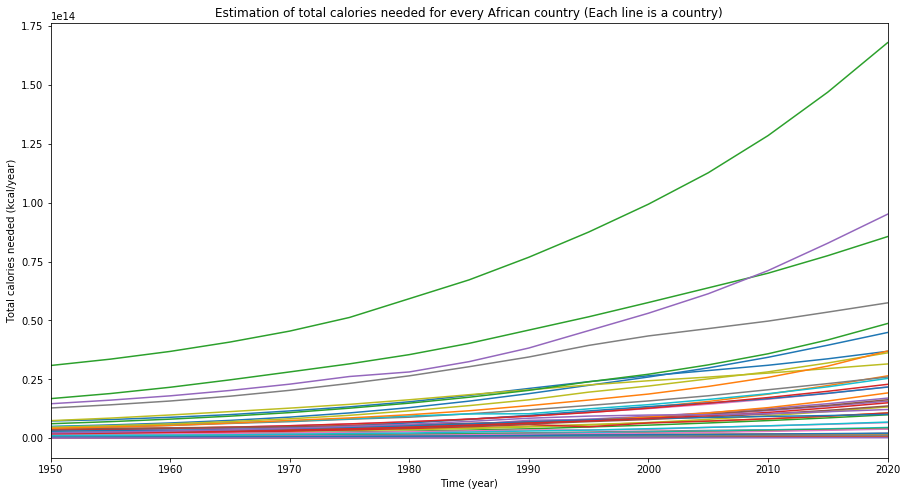

In [80]:
plt.plot(total_cal_final.T);
plt.xlabel('Time (year)')
plt.ylabel("Total calories needed (kcal/year)")
plt.title("Estimation of total calories needed for every African country (Each line is a country)")
plt.xlim(1950, 2020);

## 3) Which countries are in food deficit?
Next, an interesting comparison is introduced between the two dataframes we have obtained in the fist part of our analysis. More specifically, the analysis will take into account the total population dataframe `pop_tot` and the `FAO_food_supply_cleared`. With regard to the FAO Dataframe of food supply, we will need to transform the unit in **kcal/year** in order to compare results appropriately.

Firstly we transform the supply in **kcal/person/year**:

In [81]:
#Run this just one time otherwise you transpose it multiple times and it messes things up
FAO_food_supply_cleared = FAO_food_supply_cleared.transpose()
FAO_food_supply_cleared = (FAO_food_supply_cleared*365)

In [82]:
pop_tot_to_mult = pop_tot.copy()
FAO_food_suppl_to_mult = FAO_food_supply_cleared.copy()

In [83]:
FAO_food_supply_final = pop_tot_to_mult.multiply(FAO_food_suppl_to_mult)

In [84]:
FAO_food_supply_final = FAO_food_supply_final.dropna(axis=1, how="all")
FAO_food_supply_final.head()

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Algeria,6.710934e+12,6.674684e+12,6.666803e+12,6.887005e+12,7.288484e+12,7.416379e+12,8.005295e+12,8.530447e+12,8.763686e+12,8.843534e+12,...,4.312569e+13,4.475884e+13,4.598956e+13,4.664687e+13,4.776855e+13,4.895380e+13,5.008084e+13,5.117665e+13,5.225466e+13,5.334307e+13
Angola,3.621341e+12,3.705549e+12,3.817507e+12,3.878952e+12,3.953448e+12,3.997357e+12,4.079720e+12,3.957906e+12,4.166847e+12,4.224713e+12,...,2.131539e+13,2.189975e+13,2.353478e+13,2.427712e+13,2.524739e+13,2.622416e+13,2.722038e+13,2.813566e+13,2.908489e+13,3.001053e+13
Benin,1.566210e+12,1.611820e+12,1.586350e+12,1.579137e+12,1.740991e+12,1.770175e+12,1.836095e+12,1.977815e+12,1.950639e+12,1.926162e+12,...,8.984475e+12,9.288278e+12,9.583515e+12,9.948075e+12,1.024907e+13,1.061281e+13,1.096088e+13,1.130149e+13,1.165498e+13,1.199528e+13
Botswana,3.708512e+11,3.662568e+11,3.865872e+11,4.006369e+11,4.098191e+11,4.075888e+11,4.307136e+11,4.498575e+11,4.512586e+11,4.662503e+11,...,1.670762e+12,1.744323e+12,1.755093e+12,1.765075e+12,1.785010e+12,1.830387e+12,1.864786e+12,1.900713e+12,1.938663e+12,1.978387e+12
Burkina Faso,2.370780e+12,2.371595e+12,2.669318e+12,2.897900e+12,2.967350e+12,2.997787e+12,3.101772e+12,3.183682e+12,3.240315e+12,3.173901e+12,...,1.566111e+13,1.640900e+13,1.698527e+13,1.760514e+13,1.819095e+13,1.884195e+13,1.948267e+13,2.011773e+13,2.074714e+13,2.137228e+13


In [85]:
# cal_demand => cal_deficit (renaming)
# total_cal_final => total_cal_demand (renaming)
cal_demand = (FAO_food_supply_final - total_cal_final)/365
cal_demand = cal_demand.div(pop_tot_to_mult).dropna(axis=1, how="all")
cal_demand = cal_demand.dropna(axis=0, how="all")
cal_demand.head()

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Algeria,-573.589919,-620.801820,-659.153014,-644.633318,-591.233516,-612.982117,-538.630181,-481.186136,-483.657494,-515.050972,...,866.671209,928.653501,959.361778,948.583585,970.235898,987.456352,1000.135891,1010.292070,1018.926459,1027.885071
Angola,-413.161895,-391.881557,-357.607490,-348.339486,-333.077345,-320.591047,-290.100518,-355.605811,-266.106978,-247.604067,...,215.152631,191.672527,280.225775,272.180470,287.053294,291.335703,297.116671,295.341752,296.596793,295.808693
Benin,-492.836248,-467.466793,-519.203353,-550.041004,-403.975119,-409.528255,-378.181242,-273.928090,-335.763279,-392.681714,...,373.935633,384.061159,391.289648,416.570021,424.066821,437.500372,446.357687,452.960538,462.203734,467.996106
Botswana,-208.233159,-272.356799,-206.603106,-174.964398,-168.433620,-225.305819,-161.230054,-118.202804,-156.220859,-133.281287,...,-24.779281,46.535339,32.790121,18.364470,17.161375,22.529753,14.085228,7.837506,4.244770,2.859400
Burkina Faso,-915.448084,-930.741495,-784.109191,-678.548155,-660.055530,-668.265460,-638.569119,-620.961863,-616.439348,-671.997508,...,458.632137,499.472919,510.440182,527.565006,538.590469,548.459064,556.289647,562.894374,568.375007,573.003074


### Visualizing the data

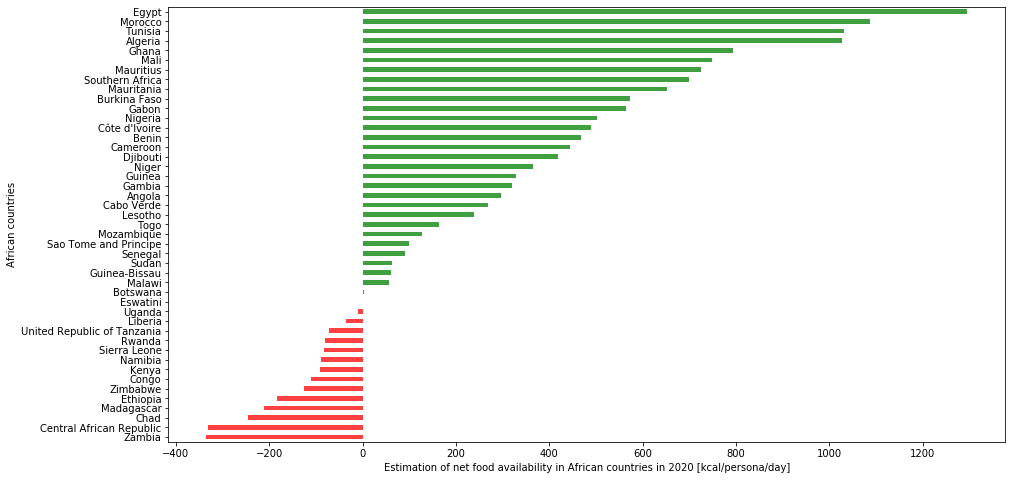

In [86]:
cal_sorted = cal_demand[2020].sort_values()
p = cal_sorted.plot(kind='barh', color=(cal_sorted > 0).map({True: 'g', False: 'red'}),alpha=0.75, rot=0);
p.set_xlabel("Estimation of net food availability in African countries in 2020 [kcal/persona/day]")
p.set_ylabel("African countries");

In [87]:
cal_demand.head()

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Algeria,-573.589919,-620.801820,-659.153014,-644.633318,-591.233516,-612.982117,-538.630181,-481.186136,-483.657494,-515.050972,...,866.671209,928.653501,959.361778,948.583585,970.235898,987.456352,1000.135891,1010.292070,1018.926459,1027.885071
Angola,-413.161895,-391.881557,-357.607490,-348.339486,-333.077345,-320.591047,-290.100518,-355.605811,-266.106978,-247.604067,...,215.152631,191.672527,280.225775,272.180470,287.053294,291.335703,297.116671,295.341752,296.596793,295.808693
Benin,-492.836248,-467.466793,-519.203353,-550.041004,-403.975119,-409.528255,-378.181242,-273.928090,-335.763279,-392.681714,...,373.935633,384.061159,391.289648,416.570021,424.066821,437.500372,446.357687,452.960538,462.203734,467.996106
Botswana,-208.233159,-272.356799,-206.603106,-174.964398,-168.433620,-225.305819,-161.230054,-118.202804,-156.220859,-133.281287,...,-24.779281,46.535339,32.790121,18.364470,17.161375,22.529753,14.085228,7.837506,4.244770,2.859400
Burkina Faso,-915.448084,-930.741495,-784.109191,-678.548155,-660.055530,-668.265460,-638.569119,-620.961863,-616.439348,-671.997508,...,458.632137,499.472919,510.440182,527.565006,538.590469,548.459064,556.289647,562.894374,568.375007,573.003074


# TRYING STUFF MANU DON'T GET MAD IF YOU SEE THIS

Importing json with geolocations to make choropleth map with FOLIUM. geoson found on internet open source

In [88]:
#FOR Everybody else
county_path = os.path.join(os.getcwd(),'data/', 'geoworld-countries.json') 
county_geojson = json.load(open(county_path))

In [89]:
african_country_codes = ["DZA","AGO","BEN","BWA","BFA","MISSING","CMR","CAF","TCD","COD","CIV",
                         "DJI","EGY","SWZ","ETH","GAB","GMB","GHA","GNQ","GNB","KEN","LSO","LBR",
                         "MDG","MWI","MLI","MRT","MISSING","MAR","MOZ","NAM","NER","NGA","RWA","MISSING"
                         ,"SEN","SLE","ZAF","SDN","TGO","TUN","UGA","TZA","ZMB","ZWE"]
countries_africa = pd.DataFrame()
countries_africa["country_name"]=cal_demand.index
countries_africa["country_code"]=african_country_codes
countries_africa.head()

,country_name,country_code
0,Algeria,DZA
1,Angola,AGO
2,Benin,BEN
3,Botswana,BWA
4,Burkina Faso,BFA


In [92]:
#Initialize map
m = folium.Map(location=[8, 15], zoom_start=3, tiles=None)
colorberew = 'RdYlGn'
legend_name = "Food supply (kcal/person/day)"
values = cal_demand[2020]
#Apply function
african_map(m,values,colorberew,legend_name)

Other way of plotting is with Bokeh:
Check this out [GUIDE](https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0)

In [91]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer